# Aufgabe 2

In [2]:
n = 4
delta_t = 0.01 # s Zeitschritt
gamma = 0.5 #  0 < gamma < 1
delta_x = 0.010/n # m  10mm breiter Abschnitt wird geteilt.
delta_y = 0.010/n # m  10mm hoher Abschnitt wird geteilt.
lambda_copper = 380 # W/(m*K)
lambda_pvc = 0.23 # W/(m*K)
c_copper = 850 # J/(kg*K)
c_pvc = 385 # J/(kg*K)
rho_copper = 8920 # kg/m^3
rho_pvc = 1400 # kg/m^3
T_u = 293.15
T_h = 373.15
t = 60 # s Beobachtungszeit

class Material:
    def __init__(self, rho, lambd, c):
        self.rho = rho
        self.lambd = lambd
        self.c = c
    
class Settings:
    def __init__(self, n, delta_t, gamma, delta_x, delta_y):
        self.n = n
        self.delta_t = delta_t
        self.gamma = gamma
        self.delta_x = delta_x
        self.delta_y = delta_y

set = Settings(n, delta_t, gamma, delta_x, delta_y)
PVC = Material(rho_pvc, lambda_pvc, c_pvc)
Cu  = Material(rho_copper, lambda_copper , c_copper)

In [3]:
class Tile:
    def __init__(self, x, y, mat, set):
        self.x = x
        self.y = y
        self.temps = []
        self.mat = mat
        self.f  = set.delta_t*set.gamma / (mat.rho*mat.c*set.delta_x*set.delta_y)
        self.g = set.delta_t *( 1-set.gamma) / (mat.rho*mat.c*set.delta_x*set.delta_y)

class CopperTile(Tile):
    def __init__(self, x, y):
        super().__init__(x, y, Cu, set)
        self.temps.append(T_h)

class PVCTile(Tile):
    def __init__(self, x, y):
        super().__init__(x, y, PVC, set)  
        self.temps.append(T_u)

In [4]:
tiles = []  # flache Liste
tile_matrix = [[None for j in range(n)] for i in range(n)]  # 2D-Liste

for i in range(n):       # i = Zeile (x-Richtung)
    pos_x = i * delta_x + delta_x / 2
    for j in range(n):   # j = Spalte (y-Richtung)
        pos_y = j * delta_y + delta_y/2
        # Bedingung für Kupferbereich (z. B. oben rechts)
        if i >= n // 2 and j < n // 2:
            
            tile = CopperTile(i, j)
        else:
            tile = PVCTile(i, j)
        
        tiles.append(tile)          # flache Liste
        tile_matrix[i][j] = tile    # 2D-Zugriff

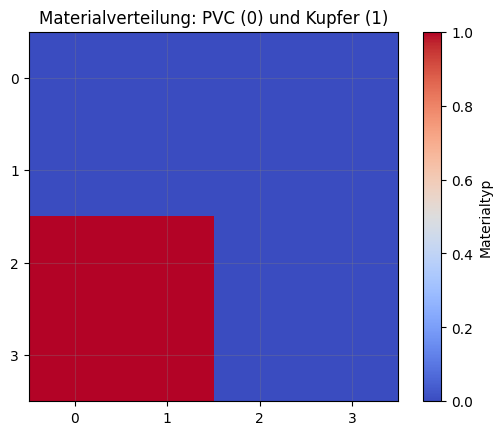

In [5]:
import numpy as np

def get_material_matrix(tile_matrix):
    n = len(tile_matrix)
    mat_array = np.zeros((n, n), dtype=int)

    for i in range(n):
        for j in range(n):
            if tile_matrix[i][j].mat == Cu:
                mat_array[i, j] = 1  # Kupfer = 1
            else:
                mat_array[i, j] = 0  # PVC = 0

    return mat_array

import matplotlib.pyplot as plt

material_map = get_material_matrix(tile_matrix)

plt.imshow(material_map, cmap='coolwarm', origin='upper')
plt.title("Materialverteilung: PVC (0) und Kupfer (1)")
plt.colorbar(label='Materialtyp')
plt.xticks(range(n))
plt.yticks(range(n))
plt.grid(True, color='gray', alpha=0.3)
plt.show()


In [15]:
import numpy as np

def create_matrix_B_2(tiles, tile_matrix):
    n = len(tile_matrix)
    N = len(tiles)
    B = np.zeros((N, N))

    for p, tile_p in enumerate(tiles):
        i = tile_p.x
        j = tile_p.y

        if tile_p.mat == Cu:
            # Dirichlet-Bedingung: Fixe Temperatur
            B[p, p] = 1
            continue

        a_p = 0  # Summe aller a_Q
        neighbors = []

        # WEST (i, j-1)
        if j - 1 >= 0:
            tile_w = tile_matrix[i][j - 1]
            a_w = (tile_p.mat.lambd + tile_w.mat.lambd) / 2
            q = i * n + (j - 1)
            B[p, q] = -tile_p.f * a_w
            a_p += a_w

        # EAST (i, j+1)
        if j + 1 < n:
            tile_e = tile_matrix[i][j + 1]
            a_e = (tile_p.mat.lambd + tile_e.mat.lambd) / 2
            q = i * n + (j + 1)
            B[p, q] = -tile_p.f * a_e
            a_p += a_e

        # NORTH (i-1, j)
        if i - 1 >= 0:
            tile_n = tile_matrix[i - 1][j]
            a_n = (tile_p.mat.lambd + tile_n.mat.lambd) / 2
            q = (i - 1) * n + j
            B[p, q] = -tile_p.f * a_n
            a_p += a_n

        # SOUTH (i+1, j)
        if i + 1 < n:
            tile_s = tile_matrix[i + 1][j]
            a_s = (tile_p.mat.lambd + tile_s.mat.lambd) / 2
            q = (i + 1) * n + j
            B[p, q] = -tile_p.f * a_s
            a_p += a_s

        # Diagonaleintrag (1 + f * a_P)
        B[p, p] = 1 + tile_p.f * a_p

    return B

In [16]:
def create_vector_F_2(tiles, tile_matrix, T_u):
    import numpy as np
    n = len(tile_matrix)
    N = len(tiles)
    F = np.zeros(N)

    for p, tile_p in enumerate(tiles):
        i = tile_p.x
        j = tile_p.y

        T_p0 = tile_p.temps[-1]
        f = tile_p.f
        g = tile_p.g

        if tile_p.mat == Cu:
            # Dirichlet: Temperatur bleibt fest
            F[p] = T_p0
            continue

        a_p = 0
        sum_neighbors = 0
        source = 0  # Ersatz für Randterm oder Quellen

        # WEST (i, j-1)
        if j - 1 >= 0:
            tile_w = tile_matrix[i][j - 1]
            a_w = (tile_p.mat.lambd + tile_w.mat.lambd) / 2
            a_p += a_w
            sum_neighbors += a_w * tile_w.temps[-1]
        else:
            # Robin-Randbedingung gegen Umgebung
            a_w = tile_p.mat.lambd
            a_p += a_w
            source += a_w * T_u

        # EAST (i, j+1)
        if j + 1 < n:
            tile_e = tile_matrix[i][j + 1]
            a_e = (tile_p.mat.lambd + tile_e.mat.lambd) / 2
            a_p += a_e
            sum_neighbors += a_e * tile_e.temps[-1]
        else:
            a_e = tile_p.mat.lambd
            a_p += a_e
            source += a_e * T_u

        # NORTH (i-1, j)
        if i - 1 >= 0:
            tile_n = tile_matrix[i - 1][j]
            a_n = (tile_p.mat.lambd + tile_n.mat.lambd) / 2
            a_p += a_n
            sum_neighbors += a_n * tile_n.temps[-1]
        else:
            a_n = tile_p.mat.lambd
            a_p += a_n
            source += a_n * T_u

        # SOUTH (i+1, j)
        if i + 1 < n:
            tile_s = tile_matrix[i + 1][j]
            a_s = (tile_p.mat.lambd + tile_s.mat.lambd) / 2
            a_p += a_s
            sum_neighbors += a_s * tile_s.temps[-1]
        else:
            a_s = tile_p.mat.lambd
            a_p += a_s
            source += a_s * T_u

        F_p = T_p0 + g * (-a_p * T_p0 + sum_neighbors + source)
        F[p] = F_p

    return F


In [17]:
F = create_vector_F_2(tiles, tile_matrix, T_u)
B = create_matrix_B_2(tiles, tile_matrix)
F


array([293.15      , 293.15      , 293.15      , 293.15      ,
       315.72395176, 315.72395176, 293.15      , 293.15      ,
       373.15      , 373.15      , 315.72395176, 293.15      ,
       373.15      , 373.15      , 315.72395176, 293.15      ])

In [18]:
import numpy as np
T1 = np.linalg.solve(B, F)

In [19]:
T1

array([293.16201311, 293.16200583, 293.15001228, 293.15000001,
       328.35261153, 328.34325535, 293.17399529, 293.15001228,
       373.15      , 373.15      , 328.34325535, 293.16200583,
       373.15      , 373.15      , 328.35261153, 293.16201311])

In [20]:
steps = int(t//delta_t)
for i in range(steps):
    F = create_vector_F_2(tiles, tile_matrix, T_u)
    T_n = np.linalg.solve(B, F)
    for temp,  tile in zip(T_n, tiles):
        tile.temps.append(temp)

In [21]:
tiles[0].temps

[293.15,
 np.float64(293.16201311459923),
 np.float64(293.1927403000876),
 np.float64(293.2338990261535),
 np.float64(293.2808580022779),
 np.float64(293.331027596615),
 np.float64(293.38295980852666),
 np.float64(293.4358450014487),
 np.float64(293.48923049174795),
 np.float64(293.5428631924991),
 np.float64(293.5966016248713),
 np.float64(293.65036671769434),
 np.float64(293.70411429614586),
 np.float64(293.7578196983062),
 np.float64(293.8114691732299),
 np.float64(293.8650550710247),
 np.float64(293.91857315329867),
 np.float64(293.9720210892499),
 np.float64(294.0253976147281),
 np.float64(294.0787020620094),
 np.float64(294.13193409686176),
 np.float64(294.18509357151964),
 np.float64(294.2381804424731),
 np.float64(294.2911947244971),
 np.float64(294.34413646494653),
 np.float64(294.3970057293823),
 np.float64(294.4498025935337),
 np.float64(294.5025271388043),
 np.float64(294.55517944975804),
 np.float64(294.60775961271395),
 np.float64(294.6602677149597),
 np.float64(294.71270

In [22]:
def get_temp_matrix(tile_matrix, k):
    n = len(tile_matrix)
    temp_array = np.zeros((n, n), dtype=float)

    for i in range(n):
        for j in range(n):
            temp_array[j, i] = tile_matrix[i][j].temps[k]

    return temp_array

import matplotlib.pyplot as plt

for k in range(len(tiles[0].temps)):
    # k = 0  # Zeitpunkt
    if k % 5 != 0:
        continue
    temp_map = get_temp_matrix(tile_matrix, k)

    plt.imshow(temp_map, cmap='coolwarm', origin='upper', extent=[0, delta_x * n, 0, delta_y * n],
           vmin=293.15, vmax=373.15)
    plt.title(f"Temperaturverteilung zu t = {round(k*delta_t, 3)} s", loc='left')
    plt.colorbar(label='Temperatur [K]')
    plt.grid(True, color='gray', alpha=0.3)

    plt.savefig(f"frames/temperatur_t{(k*delta_t):.2f}s.png", dpi=300, bbox_inches='tight')
    plt.close()


In [26]:
# pip install imageio[ffmpeg]
# pip install natsort

In [28]:
import imageio.v2 as imageio
import os
from natsort import natsorted  # optional, für richtige Reihenfolge

# Verzeichnis mit Frames
frame_dir = "frames"
filenames = natsorted([
    os.path.join(frame_dir, f) for f in os.listdir(frame_dir)
    if f.endswith(".png")
])

# Ausgabe-Datei
output_path = "temperatur_video.mp4"

# Video erstellen
with imageio.get_writer(output_path, fps=20) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"Video gespeichert als {output_path}")


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1614, 1302) to (1616, 1312) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video gespeichert als temperatur_video.mp4


In [71]:
%reset -f


# Aufgabe 3

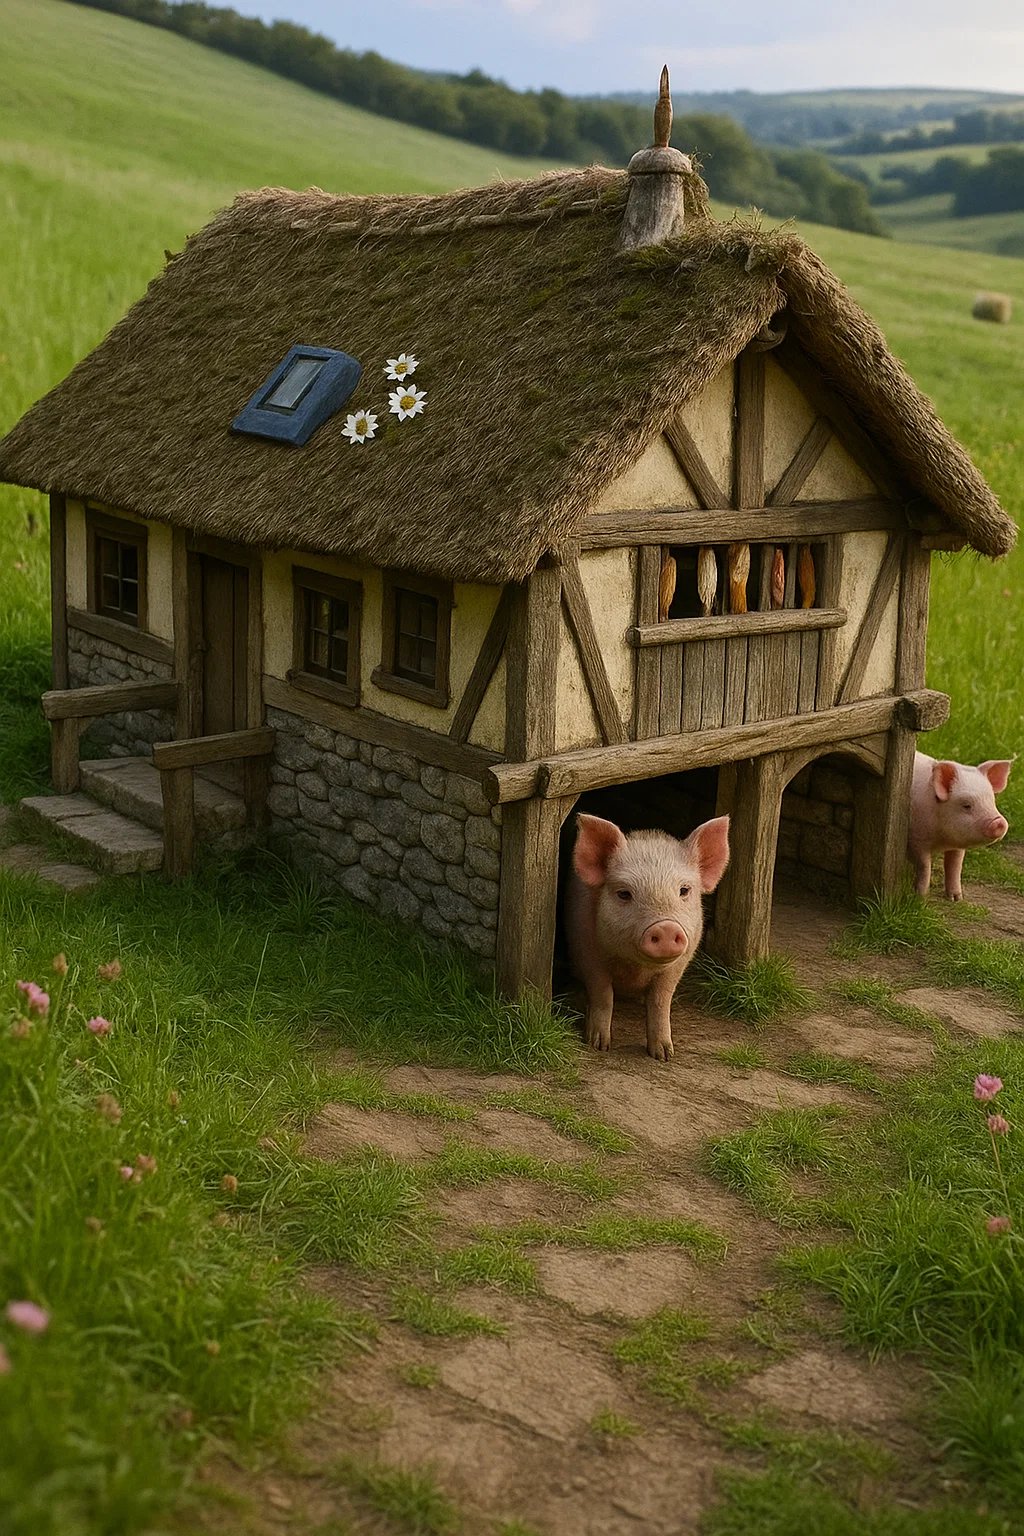

In dieser Aufgabe wird untersucht, ob Bauernhäuser im Mittelalter durch einen Stall im Keller oder Erdgeschoss beim Heizen unterstützt wurden, wobei die Körperwärme der Tiere, vorwiegend Schweine, einen Beitrag leistete.

Das Gebäude ist klein (1,95 m hoch, 1,9 m breit), aus 5 cm Holz mit 25 cm Strohisolierung. Die Außentemperatur beträgt konstant 0 °C, die Tierkörpertemperatur 25 °C. Der Stallboden ist vollständig mit Tieren bedeckt, über ihm liegt ein 5 cm dicker Holz-Zwischenboden zum Wohnraum. Zu Beginn liegt die Temperatur von Gebäude und Innenluft bei 0 °C. Die Temperaturentwicklung wird über 10 Stunden in 10-Sekunden-Schritten berechnet; die Animation zeigt alle 5 Minuten einen Frame.

Die Konvektion der Luft wird vernachlässigt. 

In [168]:
n = 40
delta_t = 10 # s Zeitschritt
gamma = 0.5 #  0 < gamma < 1
delta_x = 2/n # m  2m breiter Abschnitt wird geteilt.
delta_y = 2/n # m  2m hoher Abschnitt wird geteilt.
T_u = 273.15 # Aussentemperatur und Starttemperatur des Gebäudes
T_h = 298.15 # Temperatur der Tiere
t = 36000 # s Beobachtungszeit 10 Stunden

class Material:
    def __init__(self, rho, lambd, c):
        self.rho = rho
        self.lambd = lambd
        self.c = c
    
class Settings:
    def __init__(self, n, delta_t, gamma, delta_x, delta_y):
        self.n = n
        self.delta_t = delta_t
        self.gamma = gamma
        self.delta_x = delta_x
        self.delta_y = delta_y

set = Settings(n, delta_t, gamma, delta_x, delta_y)

# Neue Materialien
lambda_fleisch = 0.5
rho_fleisch = 1050
c_fleisch = 3500

lambda_holz = 0.15
rho_holz = 600
c_holz = 1700

lambda_luft = 0.5
rho_luft = 1.2
c_luft = 1005

lambda_stroh = 0.05
rho_stroh = 90
c_stroh = 1400

# Materialobjekte
Fleisch = Material(rho_fleisch, lambda_fleisch, c_fleisch)
Holz = Material(rho_holz, lambda_holz, c_holz)
Luft = Material(rho_luft, lambda_luft, c_luft)
Aussenluft = Material(rho_luft, lambda_luft, c_luft)  # gleich wie Luft
Stroh = Material(rho_stroh, lambda_stroh, c_stroh)

In [169]:
class Tile:
    def __init__(self, x, y, mat, set):
        self.x = x
        self.y = y
        self.temps = []
        self.mat = mat
        self.f  = set.delta_t*set.gamma / (mat.rho*mat.c*set.delta_x*set.delta_y)
        self.g = set.delta_t *( 1-set.gamma) / (mat.rho*mat.c*set.delta_x*set.delta_y)

class FleischTile(Tile):
    def __init__(self, x, y):
        super().__init__(x, y, Fleisch, set)
        self.temps.append(273.15 + 25)  # konstant 25 °C

class AussenluftTile(Tile):
    def __init__(self, x, y):
        super().__init__(x, y, Aussenluft, set)
        self.temps.append(273.15 + 0)

class LuftTile(Tile):
    def __init__(self, x, y):
        super().__init__(x, y, Luft, set)
        self.temps.append(273.15 + 0)  
        
class HolzTile(Tile):
    def __init__(self, x, y):
        super().__init__(x, y, Holz, set)
        self.temps.append(273.15 + 0)  
    
class StrohTile(Tile):
    def __init__(self, x, y):
        super().__init__(x, y, Stroh, set)
        self.temps.append(273.15 + 0)  

In [ ]:
tiles = []  # flache Liste
tile_matrix = [[None for j in range(n)] for i in range(n)]  # 2D-Liste

for i in range(n):  # x-Richtung (horizontal)
    pos_x = i * delta_x + delta_x / 2
    for j in range(n):  # y-Richtung (vertikal)
        pos_y = j * delta_y + delta_y / 2

        # Standardmaterial: Luft im Kern
        tile_class = LuftTile

        # --- Randbedingungen ---

        # Außenluft oben
        if j == n - 1:
            tile_class = AussenluftTile
        # Stroh außen (oben)
        elif n - 6 < j < n - 1:
            tile_class = StrohTile
        # Holzwand
        elif (j == n - 6 and i <= n - 6) or (j == 3 and i <= n - 6) or (j <= n - 6 and i == n - 6) or (j <= n - 6 and i == 5):
            tile_class = HolzTile
        # untere Luftschicht
        elif j in (1, 2):
            tile_class = LuftTile
        # unterste Schicht = Fleisch
        elif j == 0:
            tile_class = FleischTile

        # Aussenluft
        if i == 0 or i == n - 1:
            tile_class = AussenluftTile
        elif 1 <= i < 5 and  j < n - 1:
            tile_class = StrohTile
        # Stroh rechts
        elif n > i > n - 6 and  j < n - 1:
            tile_class = StrohTile

        # Tile erzeugen
        tile = tile_class(pos_x, pos_y)
        tiles.append(tile)
        tile_matrix[i][j] = tile

: 

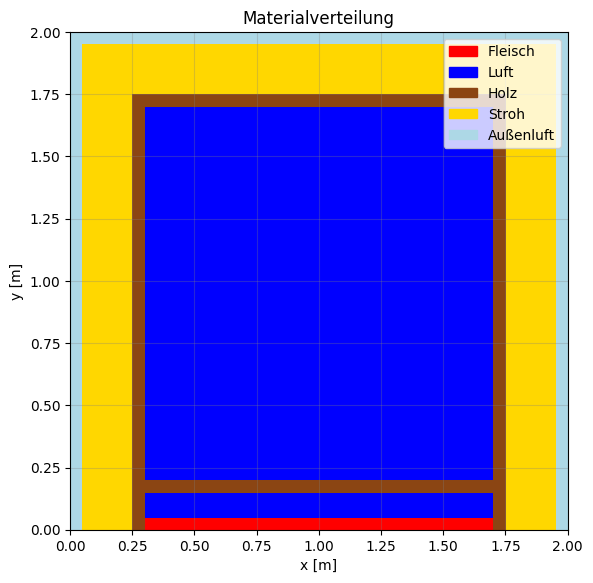

In [159]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def get_material_matrix(tile_matrix):
    n = len(tile_matrix)
    mat_array = np.zeros((n, n), dtype=int)

    for i in range(n):       # x-Achse (Spalten)
        for j in range(n):   # y-Achse (Zeilen)
            tile = tile_matrix[i][j]
            if tile.mat is Fleisch:
                mat_array[j, i] = 1
            elif tile.mat is Luft:
                mat_array[j, i] = 2
            elif tile.mat is Holz:
                mat_array[j, i] = 3
            elif tile.mat is Stroh:
                mat_array[j, i] = 4
            elif tile.mat is Aussenluft:
                mat_array[j, i] = 5
            else:
                mat_array[j, i] = 0
    return mat_array


# 2. Farben definieren
colors = ['red', 'blue', 'saddlebrown', 'gold', 'lightblue']  # für IDs 0-5
cmap = ListedColormap(colors)

# 3. Map erzeugen
material_map = get_material_matrix(tile_matrix)

plt.figure(figsize=(6, 6))
plt.imshow(material_map, cmap=cmap, origin='lower',
           extent=[0, n*delta_x, 0, n*delta_y])
plt.title("Materialverteilung")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.grid(True, color='gray', alpha=0.3)

# 4. Legende manuell erstellen
legende = [
    mpatches.Patch(color='red', label='Fleisch'),
    mpatches.Patch(color='blue', label='Luft'),
    mpatches.Patch(color='saddlebrown', label='Holz'),
    mpatches.Patch(color='gold', label='Stroh'),
    mpatches.Patch(color='lightblue', label='Außenluft'),
]

plt.legend(handles=legende, loc='upper right')
plt.tight_layout()
plt.show()

In [160]:
import numpy as np

def create_matrix_B_2(tiles, tile_matrix):
    n = len(tile_matrix)
    N = len(tiles)
    B = np.zeros((N, N))

    for p, tile_p in enumerate(tiles):
        i = p // n  # Zeile (x-Richtung)
        j = p % n   # Spalte (y-Richtung)


        if tile_p.mat == Fleisch:
            # Dirichlet-Bedingung: Fixe Temperatur
            B[p, p] = 1
            continue

        if tile_p.mat == Aussenluft:
            # Dirichlet-Bedingung: Fixe Temperatur
            B[p, p] = 1
            continue

        a_p = 0  # Summe aller a_Q
        # neighbors = []

        # WEST (i, j-1)
        if j - 1 >= 0:
            tile_w = tile_matrix[i][j - 1]
            a_w = (tile_p.mat.lambd + tile_w.mat.lambd) / 2
            q = i * n + (j - 1)
            B[p, q] = -tile_p.f * a_w
            a_p += a_w

        # EAST (i, j+1)
        if j + 1 < n:
            tile_e = tile_matrix[i][j + 1]
            a_e = (tile_p.mat.lambd + tile_e.mat.lambd) / 2
            q = i * n + (j + 1)
            B[p, q] = -tile_p.f * a_e
            a_p += a_e

        # NORTH (i-1, j)
        if i - 1 >= 0:
            tile_n = tile_matrix[i - 1][j]
            a_n = (tile_p.mat.lambd + tile_n.mat.lambd) / 2
            q = (i - 1) * n + j
            B[p, q] = -tile_p.f * a_n
            a_p += a_n

        # SOUTH (i+1, j)
        if i + 1 < n:
            tile_s = tile_matrix[i + 1][j]
            a_s = (tile_p.mat.lambd + tile_s.mat.lambd) / 2
            q = (i + 1) * n + j
            B[p, q] = -tile_p.f * a_s
            a_p += a_s

        # Diagonaleintrag (1 + f * a_P)
        B[p, p] = 1 + tile_p.f * a_p

    return B

In [161]:
def create_vector_F_2(tiles, tile_matrix, T_u):
    import numpy as np
    n = len(tile_matrix)
    N = len(tiles)
    F = np.zeros(N)

    for p, tile_p in enumerate(tiles):
        i = p // n  # Zeile (x-Richtung)
        j = p % n   # Spalte (y-Richtung)


        T_p0 = tile_p.temps[-1]
        # f = tile_p.f
        g = tile_p.g

        if tile_p.mat is Fleisch:
            # Dirichlet: Temperatur bleibt fest
            F[p] = T_p0
            continue
        
        if tile_p.mat is Aussenluft:
            # Dirichlet: Temperatur bleibt fest
            F[p] = T_p0
            continue

        a_p = 0
        sum_neighbors = 0
        source = 0  # Ersatz für Randterm oder Quellen

        # WEST (i, j-1)
        if j - 1 >= 0:
            tile_w = tile_matrix[i][j - 1]
            a_w = (tile_p.mat.lambd + tile_w.mat.lambd) / 2
            a_p += a_w
            sum_neighbors += a_w * tile_w.temps[-1]
        else:
            # Robin-Randbedingung gegen Umgebung
            a_w = tile_p.mat.lambd
            a_p += a_w
            source += a_w * T_u

        # EAST (i, j+1)
        if j + 1 < n:
            tile_e = tile_matrix[i][j + 1]
            a_e = (tile_p.mat.lambd + tile_e.mat.lambd) / 2
            a_p += a_e
            sum_neighbors += a_e * tile_e.temps[-1]
        else:
            a_e = tile_p.mat.lambd
            a_p += a_e
            source += a_e * T_u

        # NORTH (i-1, j)
        if i - 1 >= 0:
            tile_n = tile_matrix[i - 1][j]
            a_n = (tile_p.mat.lambd + tile_n.mat.lambd) / 2
            a_p += a_n
            sum_neighbors += a_n * tile_n.temps[-1]
        else:
            a_n = tile_p.mat.lambd
            a_p += a_n
            source += a_n * T_u

        # SOUTH (i+1, j)
        if i + 1 < n:
            tile_s = tile_matrix[i + 1][j]
            a_s = (tile_p.mat.lambd + tile_s.mat.lambd) / 2
            a_p += a_s
            sum_neighbors += a_s * tile_s.temps[-1]
        else:
            a_s = tile_p.mat.lambd
            a_p += a_s
            source += a_s * T_u

        F_p = T_p0 + g * (-a_p * T_p0 + sum_neighbors + source)
        F[p] = F_p

    return F


In [162]:
F = create_vector_F_2(tiles, tile_matrix, T_u)
B = create_matrix_B_2(tiles, tile_matrix)
F

array([273.15, 273.15, 273.15, ..., 273.15, 273.15, 273.15], shape=(1600,))

In [163]:
B

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], shape=(1600, 1600))

In [164]:
T1 = np.linalg.solve(B, F)
T1

array([273.15, 273.15, 273.15, ..., 273.15, 273.15, 273.15], shape=(1600,))

In [165]:
steps = int(t//delta_t)
for i in range(steps):
    F = create_vector_F_2(tiles, tile_matrix, T_u)
    T_n = np.linalg.solve(B, F)
    for temp,  tile in zip(T_n, tiles):
        tile.temps.append(temp)
tiles[800].temps

[298.15,
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.float64(298.15),
 np.

In [166]:
def get_temp_matrix(tile_matrix, k):
    n = len(tile_matrix)
    temp_array = np.zeros((n, n), dtype=float)

    for i in range(n):
        for j in range(n):
            temp_array[j, i] = tile_matrix[i][j].temps[k]

    return temp_array

import matplotlib.pyplot as plt

for k in range(len(tiles[0].temps)):
    # k = 0  # Zeitpunkt
    if k % 30 != 0:
        continue
    temp_map = get_temp_matrix(tile_matrix, k)

    plt.imshow(temp_map, cmap='coolwarm', origin='lower', extent=[0, delta_x * n, 0, delta_y * n],
           vmin=273.15, vmax=298.15)
    plt.title(f"Temperaturverteilung zu t = {round(k*delta_t, 3)} s", loc='left')
    plt.colorbar(label='Temperatur [K]')
    plt.grid(True, color='gray', alpha=0.3)

    plt.savefig(f"frames2/temperatur_t{(k*delta_t):.2f}s.png", dpi=300, bbox_inches='tight')
    plt.close()

In [167]:
import imageio.v2 as imageio
import os
from natsort import natsorted  # optional, für richtige Reihenfolge

# Verzeichnis mit Frames
frame_dir = "frames2"
filenames = natsorted([
    os.path.join(frame_dir, f) for f in os.listdir(frame_dir)
    if f.endswith(".png")
])

# Ausgabe-Datei
output_path = "schweineheizung_video.mp4"

# Video erstellen
with imageio.get_writer(output_path, fps=10) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"Video gespeichert als {output_path}")


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1587, 1302) to (1600, 1312) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video gespeichert als schweineheizung_video.mp4


In der Animation lässt sich nun sehen, dass sich in weiten Teilen des Wohnraumes eine Temperatur von 8°C eingestellt hat. Zwar wurde in den Annahmen ein unrealistisch dicht bepackter Stall angenommen und das Haus ist erstaunlich gut isoliert, aber ich bin dennoch davon überrascht, wie stark der Einfluss der Schweine ist. 